In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# **Prédiction des émissions de CO2**

In [2]:
# import des principales bibliothèques 
from matplotlib import pyplot as plt
import seaborn as sns
import time 
from datetime import datetime
import pandas as pd
import os
sns.set()
import numpy as np
from sklearn import decomposition
from sklearn import preprocessing
from matplotlib.patches import FancyArrowPatch
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore")
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from yellowbrick.regressor import ResidualsPlot, prediction_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn import svm
import folium
import time
from datetime import datetime
from geopy.distance import geodesic
from pandas.core.groupby.generic import DataFrameGroupBy

In [5]:
# Fonction permettant de calculer le RMSPE
# source : https://stackoverflow.com/questions/53165807/how-to-calculate-rmspe-in-python-using-numpy
def rmpse(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays.
    '''
    loss = np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true))))

    return loss

In [6]:
# Fonction d'évaluation des modèles de régression
def regression_metrics(y_test, y_pred):
    """Function which contains differents metrics about regression
    Input: y_test, prediction
    
    Output: MAE, MSE, RMSE, MAPE & R² score  
    """
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    rmpse_cal = rmpse(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r_score = r2_score(y_test, y_pred, multioutput="variance_weighted")
    print("MAE: ",mae.round(5))
    print("MSE: ", mse.round(5))
    print("RMSE: ", rmse)
    print("RMPSE: ", rmpse_cal.round(3))
    print("MAPE: ", mape.round(5))
    print("R²: ", r_score.round(5))

## I-Chargement des données


In [3]:
# chargement des données
path = "/content/gdrive/My Drive/P3/2016-building-energy-benchmarking.csv"
data_build = pd.read_csv(path)

In [4]:
data_build.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Address', 'City', 'State', 'ZipCode',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'DefaultData', 'Comments', 'ComplianceStatus',
       'Outlier

In [59]:
# selection de certaines variables
data=data_build.copy()
data=data[['BuildingType', 'YearBuilt','LargestPropertyUseType','DataYear',
           'NumberofFloors','NumberofBuildings', 'SecondLargestPropertyUseTypeGFA',
           'PropertyGFATotal','Latitude','Longitude','ENERGYSTARScore','SiteEnergyUseWN(kBtu)','TotalGHGEmissions']]
data=pd.concat([data.select_dtypes('object'),data.select_dtypes('int64'),data.select_dtypes('float')],axis=1)



In [58]:
data['PrimaryPropertyType'].unique()

array(['Hotel', 'Other', 'Mid-Rise Multifamily', 'Mixed Use Property',
       'K-12 School', 'University', 'Small- and Mid-Sized Office',
       'Self-Storage Facility', 'Warehouse', 'Large Office',
       'Senior Care Community', 'Medical Office', 'Retail Store',
       'Hospital', 'Residence Hall', 'Distribution Center',
       'Worship Facility', 'Low-Rise Multifamily',
       'Supermarket / Grocery Store', 'Laboratory',
       'Refrigerated Warehouse', 'Restaurant', 'High-Rise Multifamily',
       'Office'], dtype=object)

In [61]:
data['Age']=data['DataYear']-data['YearBuilt']


On s'interesse uniquement aux batiments non residentiels sur le type de construction.

In [62]:
# Transformation logarithmique des variables cibles
# L'analyse exploratoire a montré qu'elles ne suivaient pas une loi normale
data=data.loc[data['BuildingType'].isin(['NonResidential','Nonresidential COS','Nonresidential WA']),:]
data=data.loc[data['TotalGHGEmissions']>0]



OneHotEncoding

Une fois que l'on a chargé les données, on va pouvoir séparer notre jeu de données en deux parties : un train set et un test set. On ne va pas toucher aux données du test set car il nous servia pour la validation de notre modèle. C'est grâce à ce jeu de données que l'on pourra sortir les metrics nécessaires. Dans chaque jeu (entraînement et test), on supprime les variables qui ne seront pas utiles dans notre modélisation. 

Tout d'abord, on supprime les variables que l'on cherche à prédire. "SiteEnergyUseWN(kBtu)" et "TotalGHGEmissions" sont les deux cibles que l'on cherche à prédire, on les mettra donc dans une variable y. Ensuite, notre jeu de données comporte de nombreuses valeurs : certaines sont d'origine et d'autres proviennent d'une opération de feature engineering. On va donc supprimer les doublons pour éviter la fuite de donneés. 
- Le score ENERGYSTAR est enlevé car on ne va pas s'en servir pour prédire la consommation d'énergie. On regardera son impact dans la prédiction des effets de gaz à effets de serre dans un second temps. 


In [63]:
# Création d'un jeu d'entrainement (train set) et d'un jeu de test (test set)
# Stratification sur la variable "type de propriété"
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)


In [64]:
y_train = train_set[["TotalGHGEmissions"]]
y_test = test_set[["TotalGHGEmissions"]]
X_train = train_set.drop([ 'SiteEnergyUseWN(kBtu)', "TotalGHGEmissions",'ENERGYSTARScore','YearBuilt','DataYear','Latitude','Longitude'], axis=1)
X_test = test_set.drop([ 'SiteEnergyUseWN(kBtu)',"TotalGHGEmissions",'ENERGYSTARScore','YearBuilt','Latitude','DataYear','Longitude'], axis=1)


In [65]:
# Séparation des variables catégorielles et numériques
cat_var = X_train.select_dtypes('object').columns.tolist()
num_var = X_train.select_dtypes('int64').columns.tolist()+X_train.select_dtypes('float').columns.tolist()


In [66]:
# Création d'un pipeline de transformation
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy="median", fill_value="missing")),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
    ('cat', cat_pipe, cat_var),
    ('num', num_pipe, num_var)
])

In [67]:
# transformation des variables
X_train = preprocessor.fit_transform(X_train)
X_test= preprocessor.transform(X_test)

## **I-Prédiction des émissions de CO2 sans EnergyStar score**

### **1- Algorithmes de Machine Learning**

In [26]:
results = pd.DataFrame({})

**1.1-Création du modèle de base**

Le modèle choisi pour obtenir une baseline est un modèle naïf. Ce type de modèle prédit la valeur médiane de la variable cible. Le but étant d'avoir une prédiction proche de ce que ferait un modèle basé sur le hasard. 

In [24]:
from numpy.core.function_base import linspace
from sklearn.dummy import DummyRegressor

dummy_reg = DummyRegressor()
parameters={'strategy':['mean', 'median', 'quantile','constant'],
            'quantile': linspace(0.01, 1.0,5),
            'constant' : ['float','int']}
dummy_grid=GridSearchCV(dummy_reg,parameters,cv=5)  
training_start = time.perf_counter()
dummy_reg.fit(X_train, y_train)
training_end = time.perf_counter()   


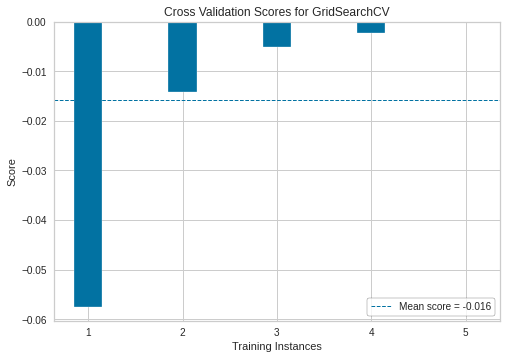

In [25]:
from yellowbrick.model_selection import cv_scores
# Instantiate the regression model and visualizer
#cv = KFold(n_splits=12, shuffle=True, random_state=42)

model = dummy_grid
visualizer1 = cv_scores(model, X_train, y_train, scoring='r2')

In [27]:
visualizer1.cv_scores_mean_

-0.01582943211774821

In [28]:
dummy_reg.score(X_train,y_train)

0.0

In [29]:
dummy_reg_train_time = training_end-training_start
dummy_reg_train_time

0.004520323000178905

In [30]:
results=results.append(pd.DataFrame({
    'Modèle' : ['Dummyregressor'],
    'Train_Score' : [dummy_reg.score(X_train,y_train)],'cv_scores_mean_':[visualizer1.cv_scores_mean_],'Time_train':[dummy_reg_train_time]}),ignore_index=True)

**1.2-Linear Regression / Ridge Regression / Lasso / Elastic Net**

Le modèle Elastic Net comprend les modèles linéaires / ridge et lasso via les valeurs des coefficients dans le grid search CV

In [22]:
from sklearn.linear_model import ElasticNet
#rappel de la fonction de coût du elasticnet
#1 / (2 * n_samples) * ||y - Xw||^2_2 + alpha * l1_ratio * ||w||_1 + 0.5 * alpha * (1 - l1_ratio) * ||w||^2_2

parameters = {'tol' : [0.1,0.01,0.001,0.0001],
              "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],  #alpha, coef qui multiplie le terme de pénalité)
              "l1_ratio": np.arange(0.0, 1.0, 0.1)}#L1 ratio , =1 équivaut à un Lasso, 0 à un Ridge

elastic_grid = GridSearchCV(estimator = ElasticNet(), 
                      param_grid = parameters,cv=5)
                      
training_start_elast = time.perf_counter()
elastic_grid.fit(X_train, y_train)
training_end_elast = time.perf_counter()   
               


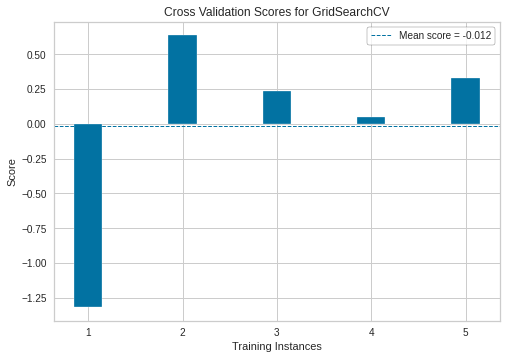

In [23]:
model = elastic_grid
visualizer2 = cv_scores(model, X_train, y_train, scoring='r2')

In [31]:
visualizer2.cv_scores_mean_

-0.01225825343062108

In [32]:
elastic_grid.best_estimator_

ElasticNet(alpha=1, l1_ratio=0.4)

In [33]:
elastic_grid.best_params_

{'alpha': 1, 'l1_ratio': 0.4, 'tol': 0.0001}

In [34]:
elastic_grid.score(X_train,y_train)

0.3697743413271517

In [35]:
elastic_grid_train_time = training_end_elast-training_start_elast
elastic_grid_train_time

105.3063700570001

In [36]:
results=results.append(pd.DataFrame({
    'Modèle' : ['ElasticNet'],
    'Train_Score' : [elastic_grid.score(X_train,y_train)],'cv_scores_mean_':[visualizer2.cv_scores_mean_],'Time_train':[elastic_grid_train_time]}),ignore_index=True)

**1.3-SVR**

In [290]:
from sklearn.svm import SVR

parameters = {'gamma' : [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1], #kernel coefficient [ici kernel = Radial Basis Function]
              'epsilon' : [0.001, 0.01, 0.1, 1], #erreur tolérée par l'algorithme
              'C' : [0.001, 0.01, 0.1, 1, 10]} #parametre de régularisation

svm = GridSearchCV(estimator = SVR(), 
                      param_grid = parameters,cv=5)
training_start_svm = time.perf_counter()
svm.fit(X_train, y_train)
training_end_svm = time.perf_counter()   
               



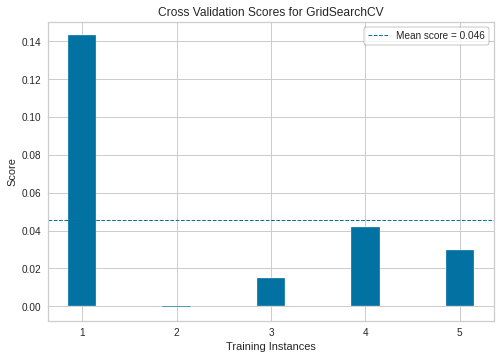

In [21]:
from yellowbrick.model_selection import cv_scores
# Instantiate the regression model and visualizer
model = svm
visualizer3 = cv_scores(model, X_train, y_train, scoring='r2')

In [37]:
visualizer3.cv_scores_

array([ 0.14317682, -0.00052538,  0.014863  ,  0.04178556,  0.02974826])

In [38]:
visualizer3.cv_scores_mean_

0.0458096506141894

In [39]:
svm.best_params_

{'C': 10, 'epsilon': 0.001, 'gamma': 0.1}

In [40]:
svm.best_estimator_

SVR(C=10, epsilon=0.001, gamma=0.1)

In [41]:
svm_train_time = training_end_svm-training_start_svm
svm_train_time

128.9158529010001

In [42]:
results=results.append(pd.DataFrame({
    'Modèle' : ['SVR'],
    'Train_Score' : [svm.score(X_train,y_train)],'cv_scores_mean_':[visualizer3.cv_scores_mean_],'Time_train':[svm_train_time]}),ignore_index=True)

**1.4- Random forest**

In [68]:
from sklearn.ensemble import RandomForestRegressor
parameters = {
'n_estimators': [50,100,300,500], #nombre d'arbres de décision
'min_samples_leaf': [1,3,5,10], #nombre de feuilles minimales dans un noeud
'max_features': ['auto', 'sqrt'] #nombre de features observées pour chaque arbre
}    
rfr_search = GridSearchCV(RandomForestRegressor(),parameters, cv=5)
training_start_rfr = time.perf_counter()
rfr_search.fit(X_train, y_train)
training_end_rfr = time.perf_counter()   
               

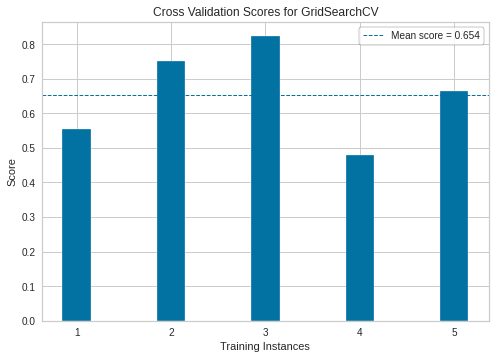

In [17]:
from yellowbrick.model_selection import cv_scores
model = rfr_search
visualizer4= cv_scores(model, X_train, y_train, scoring='r2')

In [43]:
visualizer4.cv_scores_mean_

0.6542526997093677

In [44]:
rfr_search.score(X_train,y_train)

0.9474234023247828

In [45]:
rfr_search.best_estimator_

RandomForestRegressor(max_features='sqrt')

In [46]:
rfr_search.best_params_

{'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 100}

In [47]:
rfr_search_train_time = training_end_rfr - training_start_rfr
rfr_search_train_time

180.56016428

In [48]:
results=results.append(pd.DataFrame({
    'Modèle' : ['Randomforest'],
    'Train_Score' : [rfr_search.score(X_train,y_train)],'cv_scores_mean_':[visualizer4.cv_scores_mean_],'Time_train':[rfr_search_train_time]}),ignore_index=True)

**1.5- XGBOOST**

In [429]:
from scipy.stats import randint
import xgboost as xgb
xgboost = xgb.XGBRegressor(n_jobs=-1)
parameters = {'objective':['reg:squarederror'],
              'booster':['gbtree','gblinear'],
              "n_estimators" :[200,500,800,1000]}
xgb_search = GridSearchCV(xgboost,parameters,cv=5)
training_start_xgb = time.perf_counter()
xgb_search.fit(X_train, y_train)
training_end_xgb = time.perf_counter()   
               


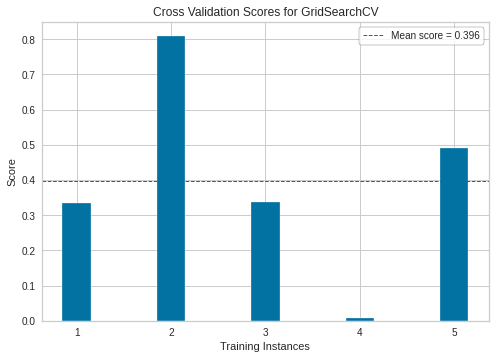

In [19]:
from yellowbrick.model_selection import cv_scores
# Instantiate the regression model and visualizer
model = xgb_search
visualizer5 = cv_scores(model, X_train, y_train, scoring='r2')

In [49]:
visualizer5.cv_scores_mean_

0.3962906900514746

In [50]:
xgb_search.best_estimator_

XGBRegressor(n_estimators=200, n_jobs=-1, objective='reg:squarederror')

In [51]:
xgb_search.score(X_train,y_train)

0.965570613693131

In [52]:
xgb_train_time = training_end_xgb - training_start_xgb
xgb_train_time

58.278412765999974

In [53]:
results=results.append(pd.DataFrame({
    'Modèle' : ['Xgboost'],
    'Train_Score' : [xgb_search.score(X_train,y_train)],'cv_scores_mean_':[visualizer5.cv_scores_mean_],'Time_train':[xgb_train_time]}),ignore_index=True)

##**2- Comparaison des modèles**

In [54]:
results

,Modèle,Train_Score,cv_scores_mean_,Time_train
0,Dummyregressor,0.000000,-0.015829,0.004520
1,ElasticNet,0.369774,-0.012258,105.306370
2,SVR,0.033236,0.045810,128.915853
3,Randomforest,0.947423,0.654253,180.560164
4,Xgboost,0.965571,0.396291,58.278413


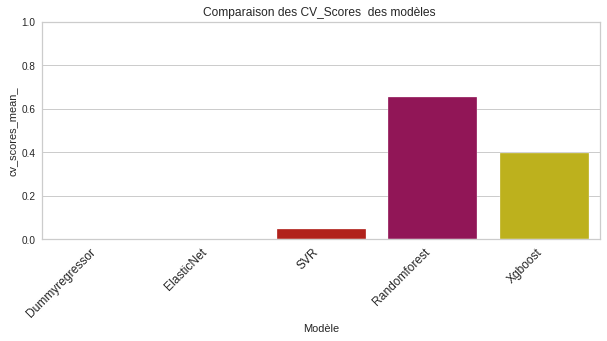

In [55]:
plt.figure(figsize=(10,4))
plt.title('Comparaison des CV_Scores  des modèles ')
chart = sns.barplot(x = results.iloc[:,0],
           y = results.iloc[:,2])
chart.set_xticklabels(labels = results.iloc[:,0], 
                      rotation=45,
                     horizontalalignment='right',
                     size=12,
                     )
ax = plt.gca()
ax.set_ylim([0,1])
plt.show()

* **XGBOOST** et **Randomforest** ont les meilleurs score de crosse validation par rapport aux autres modèles.

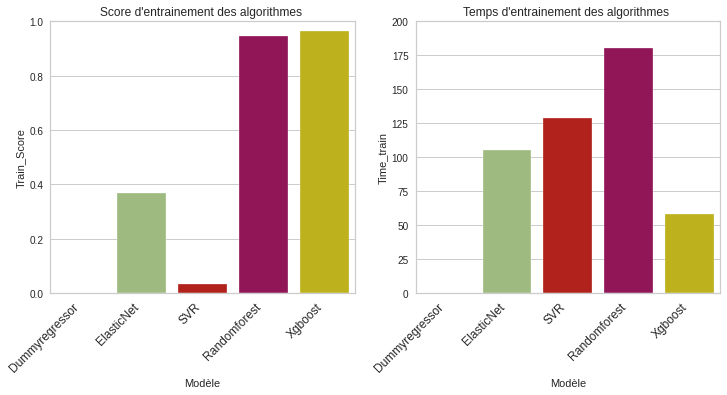

In [56]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title('Score d\'entrainement des algorithmes ')
chart = sns.barplot(x = results.iloc[:,0],
           y = results.iloc[:,1])
chart.set_xticklabels(labels = results.iloc[:,0], 
                      rotation=45,
                     horizontalalignment='right',
                     size=12,
                     )
ax = plt.gca()
ax.set_ylim([0, 1])
plt.subplot(1,2,2)
plt.title('Temps d\'entrainement des algorithmes ')
chart = sns.barplot(x = results.iloc[:,0],
           y = results.iloc[:,3])
chart.set_xticklabels(labels = results.iloc[:,0], 
                      rotation=45,
                     horizontalalignment='right',
                     size=12,
                     )
ax = plt.gca()
ax.set_ylim([0, 200])
plt.show()

Bien le temps d'exécution de XGBoost est plus faible et que son score d'entrainement est meilleur que celui de random forest,mais on choisit Random Forest Regressor pour minimiser le overfiting. 

* Modèle choisit: **Random Forest Regressor.**

##**3- Evaluation et analyse des erreurs du meilleur modèle**

In [69]:
final_model_energy = rfr_search.best_estimator_
final_predictions_energy = final_model_energy.predict(X_test)
regression_metrics(np.array(y_test), final_predictions_energy)

MAE:  94.32018
MSE:  39523.69647
RMSE:  198.80567514465858
RMPSE:  85.282
MAPE:  3.01534
R²:  0.74237


L'évaluation finale de notre modèle montre des scores plutôt bons. Notre modèle estime les émissions de CO2 avec une erreur de plus ou moins 3%. Il a un coefficient de détermination de 74%, c'est-à-dire qu'il permet d'expliquer 74% de la variance observée dans nos variables cibles. 

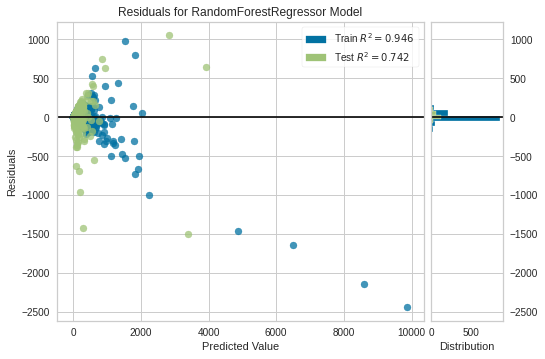

In [70]:
visualizer = ResidualsPlot(final_model_energy)
visualizer.fit(np.array(X_train), np.array(y_train).reshape( 1232,))
visualizer.score(np.array(X_test), np.array(y_test).reshape(308  ,))
visualizer.show();

La différence entre le coefficient de détermination du jeu d'entraînement et du jeu de test montre qu'il y a overfitting de notre modèle malgré les précautions prises (validation croisée, contrainte du modèle en utilisant les paramètres concernant le nombre minimum d'individus dans les noeuds et feuilles). Néanmoins notre modèle permet d'expliquer 74% de la variance expliquée mais les autres indicateurs de performances sont moins bons que pour la prédiction de la consommation d'énergie. En effet, les estimations du modèle sont moins précises et vont prédire les émissions de CO2 avec une erreur de plus ou moins 3% (RMPSE). 

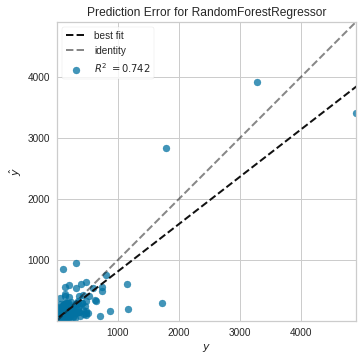

In [71]:
visualizer = prediction_error(final_model_energy, np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test));

La prédiction des émissions de CO2  semble plus complexe que celle de la consommation d'énergie. Cela peut s'expliquer par le fait que nous ne disposons pas d'informations suffisantes pour faire cette prédiction. Contrairement à la consommation d'énergie, il est possible que d'autres variables interviennent dans notre modèle ce qui expliquerait, par exemple, que notre coefficient de détermination soit plus faible et que nos performances en terme de précision de la prédiction soit moins bonne.

##**4- Bilan du modèle**
   **4.1- Feature importances**

In [73]:
feature_importance = rfr_search.best_estimator_.feature_importances_
cat_encoder = preprocessor.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder[1].categories_)
cat_one = list(cat_one_hot_attribs[0])
cat_two = list(cat_one_hot_attribs[1])
#cat_three = list(cat_one_hot_attribs[2])
#cat_four = list(cat_one_hot_attribs[3])
#cat_five = list(cat_one_hot_attribs[4])
attributes = num_var + cat_one + cat_two 
importances = pd.DataFrame(feature_importance.round(3), attributes).reset_index()
importances.columns = ["Features", "Features Importances"]


In [74]:
coefficients = abs(feature_importance)
liste_coefs_rer = pd.concat((pd.DataFrame(importances.iloc[:,0], columns = ["Features"]), 
                      pd.DataFrame(coefficients, columns = ['Coefficient'])), axis = 1).sort_values(by='Coefficient', ascending = False)
importances.sort_values("Features Importances", ascending=False).head(10)

,Features,Features Importances
12,Courthouse,0.207
57,Urgent Care/Clinic/Other Outpatient,0.200
55,Strip Mall,0.190
58,Worship Facility,0.141
54,Social/Meeting Hall,0.089
56,Supermarket/Grocery Store,0.073
24,Medical Office,0.026
15,Financial Office,0.013
13,Data Center,0.013
25,Movie Theater,0.006


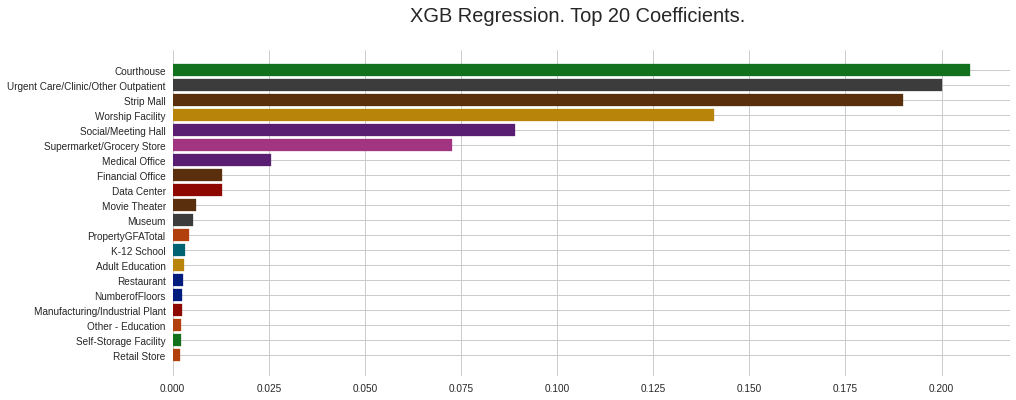

In [75]:
plt.figure(figsize=(15,6))
color_list =  sns.color_palette("dark", len(attributes)) 
top_x = 20
idx = np.argsort(np.abs(feature_importance))[::-1] 
lreg_ax = plt.barh(liste_coefs_rer["Features"][idx[:top_x]][::-1], liste_coefs_rer["Coefficient"][idx[:top_x]][::-1])
for i,bar in enumerate(lreg_ax):
  bar.set_color(color_list[idx[:top_x][::-1][i]])
  plt.box(False) 
lr_title = plt.suptitle("XGB Regression. Top " + str(top_x) + " Coefficients.", fontsize=20, fontweight="normal")


In [76]:
!pip install shap
import shap
shap.initjs()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 4.5 MB/s 


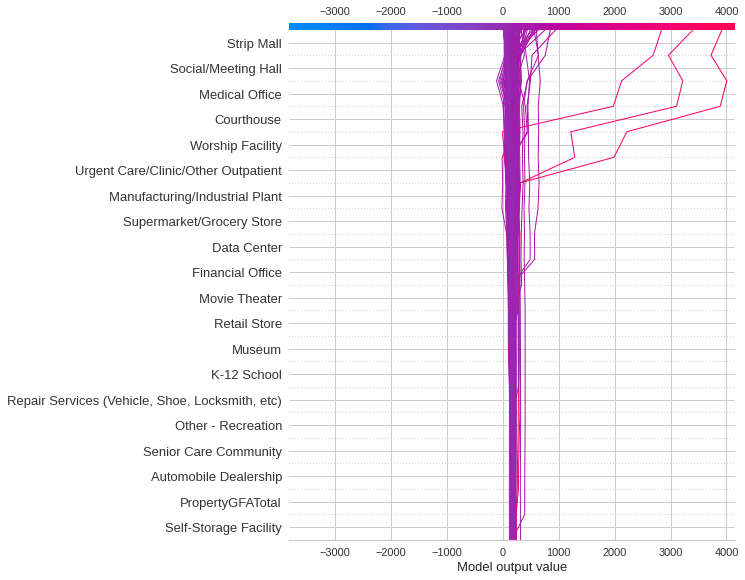

In [77]:
explainer = shap.Explainer(final_model_energy)
expected_value = explainer.expected_value
#print("The expected value is ", expected_value)
#print("The final prediction is ", xgb_model.predict(X_test)[0])
shap_values = explainer.shap_values(X_test)
shap.decision_plot(expected_value, shap_values, X_test, feature_names=attributes)

L'analyse de l'importance des features montre que l'age et le type d'usage vont être un des points importants de notre modèle. Il va s'agir des types d'usage secondaire ou tertiaire essentiellement. La présence d'un Movie Theater,
Hospital et d'un Fitness Center/Health Club/Gym vont avoir un rôle à jouer même si cela sera moins important. 

### **5- Pipeline du modèle pour l'estimation des émissions de CO2**

In [ ]:
# création de pipeline contenant la transformation des variables et le modèle entraîné
# elle peut être utilisée pour faire des prédictions sur de nouvelles variables

full_pipeline_energy = Pipeline([
    ("preprocessing", preprocessor),
    ("model", final_model_energy)
])

Le modèle choisi est prêt à être déployé pour pouvoir prédire la consommation d'énergie. Il pourra être intéressant de le réentraîner en ne faisant aucune modification logarithmique de notre cible. 

## **II- Prédiction des émissions de CO2  avec EnergyStar score**

Cette fois-ci, on va regarder si l'ajout du score ENERGY STAR va permettre d'améliorer notre modèle.


### **1- Algorithmes de Machine Learning**

In [267]:
#dat=data.dropna(subset=['ENERGYSTARScore'])

In [268]:
# Création d'un jeu d'entrainement (train set) et d'un jeu de test (test set)
# Stratification sur la variable "type de propriété"
#train_set, test_set = train_test_split(dat, test_size=0.2, random_state=42)


In [78]:
y_train_s = train_set[["TotalGHGEmissions"]]
y_test_s = test_set[["TotalGHGEmissions"]]
X_train_s = train_set.drop([ 'SiteEnergyUseWN(kBtu)', "TotalGHGEmissions",'YearBuilt','DataYear','Latitude','Longitude'], axis=1)
X_test_s = test_set.drop([ 'SiteEnergyUseWN(kBtu)',"TotalGHGEmissions",'YearBuilt','DataYear','Latitude','Longitude'], axis=1)


In [79]:
# Séparation des variables catégorielles et numériques
cat_var = X_train_s.select_dtypes('object').columns.tolist()
num_var = X_train_s.select_dtypes('int64').columns.tolist()+X_train_s.select_dtypes('float').columns.tolist()


In [80]:
# Création d'un pipeline de transformation
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy="median", fill_value="missing")),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
    ('cat', cat_pipe, cat_var),
    ('num', num_pipe, num_var)
])

In [81]:
# transformation des variables
X_train_s = preprocessor.fit_transform(X_train_s)
X_test_s= preprocessor.transform(X_test_s)

In [ ]:
results = pd.DataFrame({})

**1.1-Modèle base line**

In [ ]:
from numpy.core.function_base import linspace
from sklearn.dummy import DummyRegressor

dummy_reg = DummyRegressor()
parameters={'strategy':['mean', 'median', 'quantile','constant'],
            'quantile': linspace(0.01, 1.0,5),
            'constant' : ['float','int']}
dummy_grid=GridSearchCV(dummy_reg,parameters,cv=5)  
training_start = time.perf_counter()
dummy_reg.fit(X_train_s, y_train_s)
training_end = time.perf_counter() 

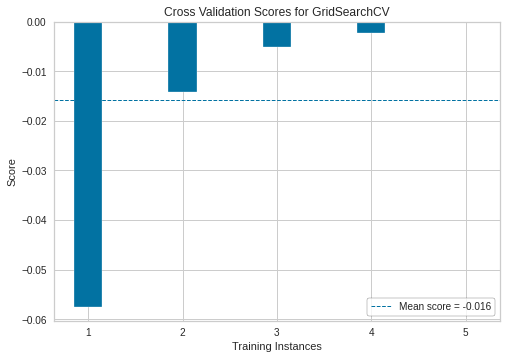

In [ ]:
from yellowbrick.model_selection import cv_scores
# Instantiate the regression model and visualizer
#cv = KFold(n_splits=12, shuffle=True, random_state=42)

model = dummy_grid
visualizer1 = cv_scores(model, X_train_s, y_train_s, scoring='r2')

In [ ]:
visualizer1.cv_scores_mean_

-0.01582943211774821

In [ ]:
dummy_reg_train_time=training_end-training_start

In [ ]:
dummy_reg.score(X_train,y_train)

0.0

In [ ]:
results=results.append(pd.DataFrame({
    'Modèle' : ['Dummyregressor'],
    'Train_Score' : [dummy_reg.score(X_train,y_train)],'cv_scores_mean_':[visualizer1.cv_scores_mean_],'Time_train':[dummy_reg_train_time]}),ignore_index=True)

**1.2-ElasticNet**

In [ ]:
from sklearn.linear_model import ElasticNet
#rappel de la fonction de coût du elasticnet
#1 / (2 * n_samples) * ||y - Xw||^2_2 + alpha * l1_ratio * ||w||_1 + 0.5 * alpha * (1 - l1_ratio) * ||w||^2_2

parameters = {'tol' : [0.1,0.01,0.001,0.0001],
              "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],  #alpha, coef qui multiplie le terme de pénalité)
              "l1_ratio": np.arange(0.0, 1.0, 0.1)}#L1 ratio , =1 équivaut à un Lasso, 0 à un Ridge

elastic_grid = GridSearchCV(estimator = ElasticNet(), 
                      param_grid = parameters,cv=5)
                      
training_start_elast = time.perf_counter()
elastic_grid.fit(X_train_s, y_train_s)
training_end_elast = time.perf_counter()  

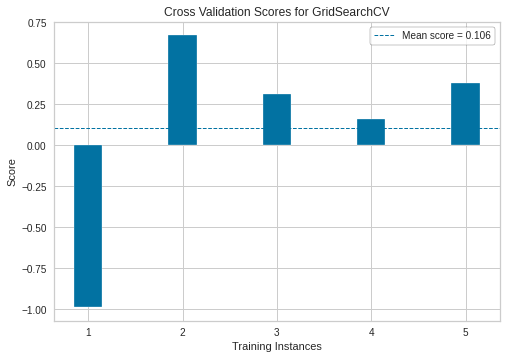

In [ ]:
visualizer2 = cv_scores(elastic_grid, X_train_s, y_train_s, scoring='r2')

In [ ]:
elastic_grid_train_time=training_end_elast-training_start_elast

In [ ]:
results=results.append(pd.DataFrame({
    'Modèle' : ['ElasticNet'],
    'Train_Score' : [elastic_grid.score(X_train_s,y_train_s)],'cv_scores_mean_':[visualizer2.cv_scores_mean_],'Time_train':[elastic_grid_train_time]}),ignore_index=True)

**1.3-SVR**

In [ ]:
from sklearn.svm import SVR

parameters = {'gamma' : [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1], #kernel coefficient [ici kernel = Radial Basis Function]
              'epsilon' : [0.001, 0.01, 0.1, 1], #erreur tolérée par l'algorithme
              'C' : [0.001, 0.01, 0.1, 1, 10]} #parametre de régularisation

svm = GridSearchCV(estimator = SVR(), 
                      param_grid = parameters,cv=5)
training_start_svm = time.perf_counter()
svm.fit(X_train_s, y_train_s)
training_end_svm = time.perf_counter()   
               



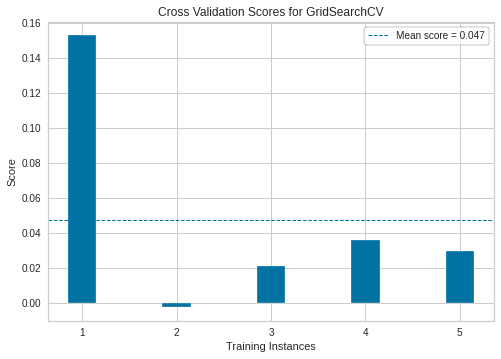

In [ ]:
visualizer3= cv_scores(svm, X_train_s, y_train_s, scoring='r2')

In [ ]:
svm_train_time=training_end_svm-training_start_svm

In [ ]:
results=results.append(pd.DataFrame({
    'Modèle' : ['SVR'],
    'Train_Score' : [svm.score(X_train_s,y_train_s)],'cv_scores_mean_':[visualizer3.cv_scores_mean_],'Time_train':[svm_train_time]}),ignore_index=True)

**1.4-RandomForest**

In [82]:
from sklearn.ensemble import RandomForestRegressor

parameters = {
    'n_estimators' : [50,100,300,500], #nombre d'arbres de décision
    'min_samples_leaf' : [1,3,5,10], #nombre de feuilles minimales dans un noeud
    'max_features': ['auto', 'sqrt'] #nombre de features observées pour chaque arbre
}    
        
rfr_search = GridSearchCV(RandomForestRegressor(),parameters, cv=5)
training_start_rfr = time.perf_counter()
rfr_search.fit(X_train_s, y_train_s)
training_end_rfr = time.perf_counter()   
               

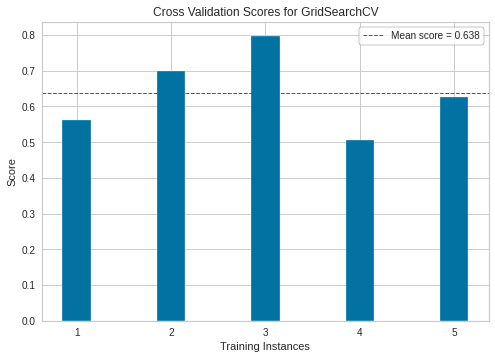

In [ ]:
visualizer4= cv_scores(rfr_search, X_train_s, y_train_s, scoring='r2')

In [ ]:
rfr_search_train_time=training_end_rfr-training_start_rfr

In [ ]:
results=results.append(pd.DataFrame({
    'Modèle' : ['Randomforest'],
    'Train_Score' : [rfr_search.score(X_train_s,y_train_s)],'cv_scores_mean_':[visualizer4.cv_scores_mean_],'Time_train':[rfr_search_train_time]}),ignore_index=True)

**1.5-XGBOOST**

In [ ]:
from scipy.stats import randint
import xgboost as xgb
xgboost = xgb.XGBRegressor(n_jobs=-1)
parameters = {'objective':['reg:squarederror'],
              'booster':['gbtree','gblinear'],
              "n_estimators" :[200,500,800,1000]}
xgb_search = GridSearchCV(xgboost,parameters,cv=5)
training_start_xgb = time.perf_counter()
xgb_search.fit(X_train_s, y_train_s)
training_end_xgb = time.perf_counter()   
               

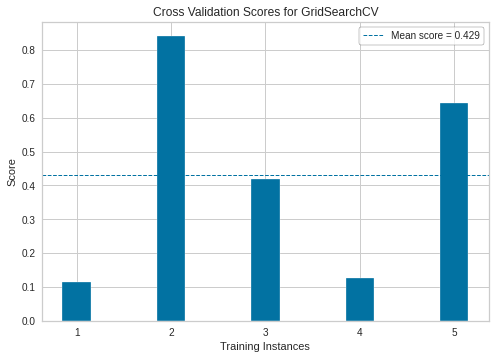

In [ ]:
visualizer5= cv_scores(xgb_search, X_train_s, y_train_s, scoring='r2')

In [ ]:
xgb_train_time=training_end_xgb-training_start_xgb

In [ ]:
results=results.append(pd.DataFrame({
    'Modèle' : ['XGBOOST'],
    'Train_Score' : [xgb_search.score(X_train_s,y_train_s)],'cv_scores_mean_':[visualizer5.cv_scores_mean_],'Time_train':[xgb_train_time]}),ignore_index=True)

**2-Comparaison des modèles**

In [ ]:
results

,Modèle,Train_Score,cv_scores_mean_,Time_train
0,Dummyregressor,0.000000,-0.015829,0.002777
1,ElasticNet,0.681158,0.106419,107.594254
2,SVR,0.031331,0.047410,123.306075
3,Randomforest,0.957199,0.638120,205.241327
4,XGBOOST,0.972832,0.429472,64.025060


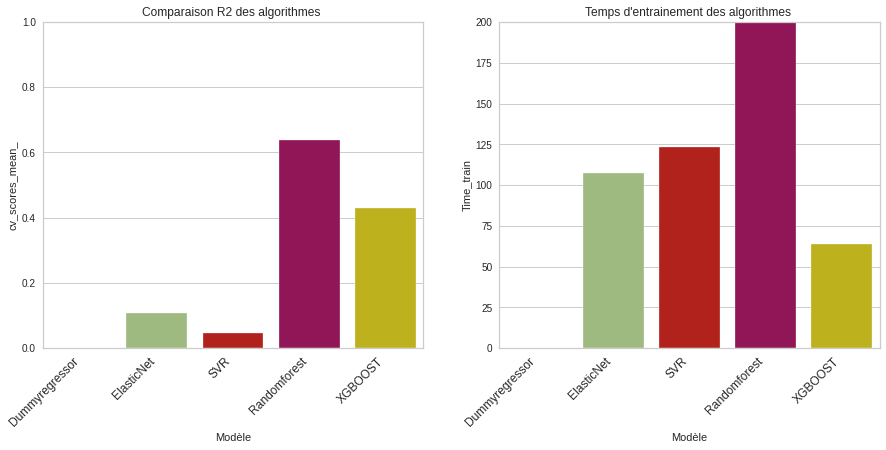

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.title('Comparaison R2 des algorithmes ')
chart = sns.barplot(x = results.iloc[:,0],
           y = results.iloc[:,2])
chart.set_xticklabels(labels = results.iloc[:,0], 
                      rotation=45,
                     horizontalalignment='right',
                     size=12,
                     )
ax = plt.gca()
ax.set_ylim([0, 1])
plt.subplot(1,2,2)
plt.title('Temps d\'entrainement des algorithmes ')
chart = sns.barplot(x = results.iloc[:,0],
           y = results.iloc[:,3])
chart.set_xticklabels(labels = results.iloc[:,0], 
                      rotation=45,
                     horizontalalignment='right',
                     size=12,
                     )
ax = plt.gca()
ax.set_ylim([0, 200])
plt.show()

* **XGBOOST** et **Randomforest** ont les meilleurs score de crosse avlidation par rapport aux autres modèles. De plus le temps d'exécution de XGBoost est plus faible que celui de random forest, ceci pourrait être un critère pour choisir toujours XGBoost plutôt que  Random Forest Regressor.

**3-Evaluation et analyse des erreurs du modèles**

In [83]:
final_model_energy_s = rfr_search.best_estimator_
final_predictions_energy_s = final_model_energy_s.predict(X_test_s)
regression_metrics(np.array(y_test_s), final_predictions_energy_s)

MAE:  90.82267
MSE:  39396.40888
RMSE:  198.48528631120732
RMPSE:  81.073
MAPE:  2.82694
R²:  0.7432


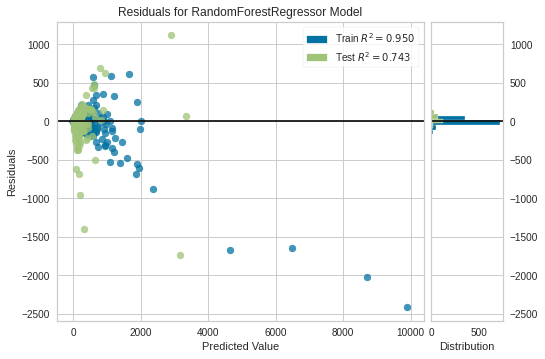

In [84]:
visualizer_s = ResidualsPlot(final_model_energy_s)
visualizer_s.fit(np.array(X_train_s), np.array(y_train_s).reshape( 1232,))
visualizer_s.score(np.array(X_test_s), np.array(y_test_s).reshape(308,))
visualizer_s.show();

Comme pour la prédiction sans utiliser le score ENERGY STAR, on observe un effet important de surapprentissage. On remarque aussi que les erreurs de précision des prédictions ne sont pas améliorés. L'ajout du score Energy Star ne permet pas de mieux expliquer le fait et ne va pas améliorer la précision du modèle. On peut donc se passer de cette variable dans notre prédiction. 

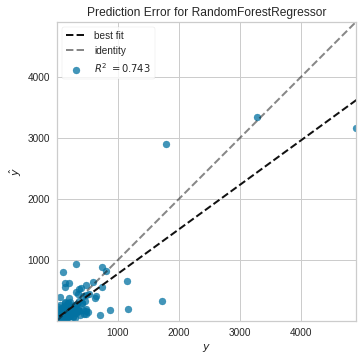

In [85]:
visualizer_s= prediction_error(final_model_energy_s, np.array(X_train_s), np.array(y_train_s), np.array(X_test_s), np.array(y_test_s));

**4-Interet de l'energystar score**

In [86]:
def met(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    rmpse_cal = rmpse(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r_score = r2_score(y_test, y_pred, multioutput="variance_weighted")
    return[mae,mse,rmse,rmpse_cal,mape,r_score]

In [87]:
metric=pd.DataFrame({'Metrics':['MAE','MSE','RMSE','RMPSE','MAPE','R2'],'Sans_Energystar_Score':met(np.array(y_test), final_predictions_energy),'Avec_EnergyStar_Score':met(np.array(y_test_s), final_predictions_energy_s)})
metric

,Metrics,Sans_Energystar_Score,Avec_EnergyStar_Score
0,MAE,94.320177,90.822672
1,MSE,39523.696470,39396.408882
2,RMSE,198.805675,198.485286
3,RMPSE,85.282324,81.072727
4,MAPE,3.015336,2.826937
5,R2,0.742367,0.743197


Le résultat obtenu ici avec le Energy Star Score améliore très légèrement la performance du meilleur modèle et semble donc peu pertinent . Cependant, dans la mesure où:
* il est manquant pour un certain nombre de données de l'échantillon (et donc potentiellement des futurs bâtiments pour lesquels il faudra faire tourner le modèle)
* il est fastidieux à calculer

On peut tout à fait se passer du Energy Star Score au prix d'un modèle légèrement moins précis (cf parties précédentes du notebook) mais avec une complexité moindre pour l'ensemble du processus. Dans le cas où les équipes parviendraient à estimer de façon simple le Energy Star Score, la question serait à reconsidérer et il serait alors pertinent de l'intégrer au modèle

## conclusion

La prédiction de CO2 semble moins fiable avec une erreur de plus ou moins 3%. L'ajout d'une variable supplémentaire comme le score Energy Star ne va pas modifier les scores de la prédiction. Ce modèle peut être utilisé pour nos prédictions mais il faudra prendre en compte que les erreurs sont plus importantes que pour la consommation d'énergie d'un bâtiment. 